In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

import SALib.analyze.morris
from SALib.sample import morris

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from tqdm import tqdm

from infrasim.optimise import *
from infrasim.utils import *

In [7]:
def process_morris_results(problem,param_values,collected_results,num_levels):
    '''Process output from Morris sensitivitys
    '''
    Si = SALib.analyze.morris.analyze(problem,
                                      np.array(param_values),
                                      np.array(collected_results),
                                      print_to_console=False,
                                      num_levels=num_levels)

    sensitivity_results = pd.DataFrame.from_dict(Si)
    return sensitivity_results


def calculate_relative_influence(sensitivity_results):
    '''Return relative influence (%) of each parameter from sensitivity
    '''
    sensitivity = sensitivity_results.copy()
    sensitivity['rel'] = abs(sensitivity['mu'])/abs(sensitivity['mu']).sum()*100
    sensitivity['mu'] = sensitivity['mu']
    sensitivity = sensitivity[['names','rel']]
    sensitivity = sensitivity.sort_values(by='names',ascending=True).reset_index(drop=True)
    sensitivity.names = sensitivity.names.str.replace('_',' ')
    sensitivity.names = sensitivity.names.str.title()
    sensitivity.names = sensitivity.names.str.replace('Res','RES')
    sensitivity.names = sensitivity.names.str.replace('Coop','COO')
    sensitivity.names = sensitivity.names.str.replace('To','to')
    sensitivity.names = sensitivity.names.str.replace('Westbank','West Bank')
    return sensitivity


def read_results(path='../data/gsa_results/combined_capacities_100_generations.csv'):
    # read results
    combined_caps = pd.read_csv(path)
    # israel
    israel_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Israel'].to_list(),
                                            num_levels)
    # jordan
    jordan_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Jordan'].to_list(),
                                            num_levels)
    # west bank
    westbank_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['West Bank'].to_list(),
                                            num_levels)
    # gaza
    gaza_results = process_morris_results(problem,
                                            param_values,
                                            combined_caps['Gaza'].to_list(),
                                            num_levels)
    # return
    return combined_caps,israel_results,jordan_results,westbank_results,gaza_results


def min_max_avg_plot(df,ax=None):
    # line plot
    sns.lineplot(x='value',y='variable',data=df,
                 linewidth=1,zorder=10,color='firebrick',ax=ax)
    # high and low
    sns.scatterplot(x='value',y='variable',data=df[df.stat != 'average'],
                    marker='|',s=100,color='firebrick',zorder=15,ax=ax)
    # mean
    sns.scatterplot(x='value',y='variable',data=df[df.stat == 'average'],
                    marker='o',s=100,color='firebrick',zorder=15,ax=ax)

In [3]:
#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# params
count       = 1
save_iter   = 25
timesteps   = None
num_levels  = 10
N           = 10

# Set up problem for sensitivity analysis # name:[lower_bound,upper_bound]
params = {'coop_res_target'                 : [0,0.7],
          'jordan_to_westbank'              : [0,10**12],
          'jordan_to_israel'                : [0,10**12],
          'israel_to_westbank'              : [0,10**12],
          'israel_to_jordan'                : [0,10**12],
          'israel_to_gaza'                  : [0,10**12],
          'westbank_to_israel'              : [0,10**12],
          'westbank_to_jordan'              : [0,10**12],
          'self_sufficiency_factor'         : [0,0.9],
         }

problem = {'num_vars'    : len(params.keys()),
           'names'       : [i for i in params.keys()],
           'bounds'      : [params[i] for i in params.keys()]
          }

# create parameter values
param_values = morris.sample(problem,N=N,
                             num_levels=num_levels,
                             local_optimization=True)

# Run analysis with the specified parameter values
collected_caps_israel   = []
collected_caps_jordan   = []
collected_caps_westbank = []
collected_caps_gaza     = []

for param_set in tqdm(param_values,total=len(param_values)):

    model_run = nextra(nodes,edges,flows,
                       timesteps=timesteps,
                       energy_objective=True,
                       scenario='COO',
                       super_sink=False,
                       super_source=False,
                       # params
                       coo_res_factor=param_set[0],
                       jordan_to_westbank=param_set[1],
                       jordan_to_israel=param_set[2],
                       israel_to_westbank=param_set[3],
                       israel_to_jordan=param_set[4],
                       israel_to_gaza=param_set[5],
                       westbank_to_israel=param_set[6],
                       westbank_to_jordan=param_set[7],
                       self_sufficiency_factor=param_set[8],
                      )
    
    # build, run, and get results
    model_run.build()
    model_run.run(pprint=False)
    model_results = model_run.get_results()
    
    # get capacities
    caps = model_results.results_capacity_change[\
                model_results.results_capacity_change.capacity_change >= 0].reset_index(drop=True)
    caps = caps.groupby(by=['node','territory']).max().reset_index()
    caps = caps.groupby(by='territory').sum().reset_index()
    
    # append collected capacities
    collected_caps_israel.append(caps.loc[caps.territory == 'Israel','capacity_change'].values[0])
    collected_caps_jordan.append(caps.loc[caps.territory == 'Jordan','capacity_change'].values[0])
    collected_caps_westbank.append(caps.loc[caps.territory == 'West Bank','capacity_change'].values[0])
    collected_caps_gaza.append(caps.loc[caps.territory == 'Gaza','capacity_change'].values[0])
    
    # make dataframes
    combined_caps = pd.DataFrame({'Israel' : collected_caps_israel,
                                  'Jordan' : collected_caps_jordan,
                                  'West Bank' : collected_caps_westbank,
                                  'Gaza' : collected_caps_gaza,})
    
    # save
    if count % save_iter == 0:
        combined_caps.to_csv('../data/gsa_results/combined_capacities_' + str(count) + '_generations.csv',index=False)
    
    # adjust counter
    count = count + 1

  0%|                                                   | 0/100 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-03



  1%|▍                                       | 1/100 [02:39<4:23:52, 159.92s/it]

  2%|▊                                       | 2/100 [05:21<4:22:37, 160.79s/it]

  3%|█▏                                      | 3/100 [08:04<4:21:25, 161.71s/it]

  4%|█▌                                      | 4/100 [10:44<4:18:03, 161.28s/it]

  5%|██                                      | 5/100 [13:28<4:16:54, 162.26s/it]

  6%|██▍                                     | 6/100 [16:17<4:17:36, 164.43s/it]

  7%|██▊                                     | 7/100 [19:04<4:16:20, 165.38s/it]

  8%|███▏                                    | 8/100 [21:51<4:14:30, 165.98s/it]

  9%|███▌                                    | 9/100 [24:39<4:12:29, 166.48s/it]

 10%|███▉                                   | 10/100 [27:25<4:09:21, 166.24s/it]

 11%|████▎                                  | 11/100 [30:07<4:04:53, 165.10s/it]

 12%|████▋                                  | 12/100 [32:48<4:00:04, 163.69s/it]

 13%|█████                                  | 13/100 [35:28<3:55:48, 162.63s/it]

 14%|█████▍                                 | 14/100 [38:27<4:00:24, 167.73s/it]

 15%|█████▊                                 | 15/100 [41:33<4:05:26, 173.25s/it]

 16%|██████▏                                | 16/100 [44:41<4:08:27, 177.47s/it]

 17%|██████▋                                | 17/100 [47:49<4:09:58, 180.71s/it]

 18%|███████                                | 18/100 [50:54<4:08:50, 182.07s/it]

 19%|███████▍                               | 19/100 [53:52<4:04:14, 180.92s/it]

 20%|███████▊                               | 20/100 [56:52<4:00:44, 180.56s/it]

 21%|████████▏                              | 21/100 [59:39<3:52:14, 176.39s/it]

 22%|████████▏                            | 22/100 [1:02:27<3:46:09, 173.96s/it]

 23%|████████▌                            | 23/100 [1:05:16<3:41:06, 172.29s/it]

 24%|████████▉                            | 24/100 [1:08:01<3:35:43, 170.31s/it]

 25%|█████████▎                           | 25/100 [1:10:57<3:34:48, 171.85s/it]

 26%|█████████▌                           | 26/100 [1:13:53<3:33:44, 173.30s/it]

 27%|█████████▉                           | 27/100 [1:16:53<3:33:01, 175.10s/it]

 28%|██████████▎                          | 28/100 [1:19:51<3:31:07, 175.94s/it]

 29%|██████████▋                          | 29/100 [1:22:54<3:30:41, 178.06s/it]

 30%|███████████                          | 30/100 [1:25:53<3:28:05, 178.36s/it]

 31%|███████████▍                         | 31/100 [1:28:47<3:23:44, 177.16s/it]

 32%|███████████▊                         | 32/100 [1:31:36<3:18:08, 174.84s/it]

 33%|████████████▏                        | 33/100 [1:34:26<3:13:27, 173.25s/it]

 34%|████████████▌                        | 34/100 [1:37:17<3:09:48, 172.55s/it]

 35%|████████████▉                        | 35/100 [1:40:08<3:06:37, 172.27s/it]

 36%|█████████████▎                       | 36/100 [1:42:56<3:02:06, 170.72s/it]

 37%|█████████████▋                       | 37/100 [1:45:49<3:00:01, 171.45s/it]

 38%|██████████████                       | 38/100 [1:48:40<2:57:14, 171.52s/it]

 39%|██████████████▍                      | 39/100 [1:51:34<2:54:59, 172.12s/it]

 40%|██████████████▊                      | 40/100 [1:54:27<2:52:22, 172.37s/it]

 41%|███████████████▏                     | 41/100 [1:57:21<2:50:04, 172.96s/it]

 42%|███████████████▌                     | 42/100 [2:00:08<2:45:29, 171.21s/it]

 43%|███████████████▉                     | 43/100 [2:02:57<2:41:55, 170.45s/it]

 44%|████████████████▎                    | 44/100 [2:05:38<2:36:24, 167.58s/it]

 45%|████████████████▋                    | 45/100 [2:08:16<2:31:04, 164.80s/it]

 46%|█████████████████                    | 46/100 [2:10:53<2:26:10, 162.41s/it]

 47%|█████████████████▍                   | 47/100 [2:13:33<2:22:40, 161.52s/it]

 48%|█████████████████▊                   | 48/100 [2:19:32<3:11:27, 220.92s/it]

 49%|██████████████████▏                  | 49/100 [2:22:06<2:50:43, 200.86s/it]

 50%|██████████████████▌                  | 50/100 [2:24:39<2:35:28, 186.57s/it]

 51%|██████████████████▊                  | 51/100 [2:27:32<2:28:54, 182.34s/it]

 52%|███████████████████▏                 | 52/100 [2:30:21<2:22:49, 178.53s/it]

 53%|███████████████████▌                 | 53/100 [2:33:19<2:19:37, 178.25s/it]

 54%|███████████████████▉                 | 54/100 [2:36:18<2:16:53, 178.55s/it]

 55%|████████████████████▎                | 55/100 [2:39:15<2:13:30, 178.01s/it]

 56%|████████████████████▋                | 56/100 [2:42:19<2:11:55, 179.90s/it]

 57%|█████████████████████                | 57/100 [2:45:25<2:10:14, 181.73s/it]

 58%|█████████████████████▍               | 58/100 [2:48:27<2:07:15, 181.81s/it]

 59%|█████████████████████▊               | 59/100 [2:51:30<2:04:26, 182.12s/it]

 60%|██████████████████████▏              | 60/100 [2:54:31<2:01:10, 181.75s/it]

 61%|██████████████████████▌              | 61/100 [2:57:23<1:56:13, 178.82s/it]

 62%|██████████████████████▉              | 62/100 [3:00:14<1:51:48, 176.53s/it]

 63%|███████████████████████▎             | 63/100 [3:03:05<1:47:51, 174.90s/it]

 64%|███████████████████████▋             | 64/100 [3:05:55<1:44:00, 173.35s/it]

 65%|████████████████████████             | 65/100 [3:08:35<1:38:45, 169.30s/it]

 66%|████████████████████████▍            | 66/100 [3:11:13<1:34:04, 166.02s/it]

 67%|████████████████████████▊            | 67/100 [3:13:53<1:30:14, 164.08s/it]

 68%|█████████████████████████▏           | 68/100 [3:16:33<1:26:51, 162.87s/it]

 69%|█████████████████████████▌           | 69/100 [3:19:12<1:23:34, 161.75s/it]

 70%|█████████████████████████▉           | 70/100 [3:21:51<1:20:26, 160.87s/it]

 71%|██████████████████████████▎          | 71/100 [3:24:20<1:16:01, 157.28s/it]

 72%|██████████████████████████▋          | 72/100 [3:27:09<1:15:01, 160.76s/it]

 73%|███████████████████████████          | 73/100 [3:30:00<1:13:49, 164.07s/it]

 74%|███████████████████████████▍         | 74/100 [3:32:51<1:11:58, 166.08s/it]

 75%|███████████████████████████▊         | 75/100 [3:35:40<1:09:31, 166.86s/it]

 76%|████████████████████████████         | 76/100 [3:38:26<1:06:39, 166.64s/it]

 77%|████████████████████████████▍        | 77/100 [3:41:13<1:03:53, 166.66s/it]

 78%|████████████████████████████▊        | 78/100 [3:43:58<1:00:58, 166.28s/it]

 79%|██████████████████████████████▊        | 79/100 [3:46:43<58:03, 165.86s/it]

 80%|███████████████████████████████▏       | 80/100 [3:49:27<55:08, 165.45s/it]

 81%|███████████████████████████████▌       | 81/100 [3:52:10<52:05, 164.49s/it]

 82%|███████████████████████████████▉       | 82/100 [3:54:55<49:24, 164.67s/it]

 83%|████████████████████████████████▎      | 83/100 [3:57:39<46:38, 164.59s/it]

 84%|████████████████████████████████▊      | 84/100 [4:00:21<43:40, 163.79s/it]

 85%|█████████████████████████████████▏     | 85/100 [4:03:04<40:51, 163.41s/it]

 86%|█████████████████████████████████▌     | 86/100 [4:06:07<39:30, 169.34s/it]

 87%|█████████████████████████████████▉     | 87/100 [4:09:07<37:22, 172.51s/it]

 88%|██████████████████████████████████▎    | 88/100 [4:12:07<34:59, 174.97s/it]

 89%|██████████████████████████████████▋    | 89/100 [4:15:08<32:22, 176.63s/it]

 90%|███████████████████████████████████    | 90/100 [4:18:07<29:33, 177.30s/it]

 91%|███████████████████████████████████▍   | 91/100 [4:20:44<25:42, 171.38s/it]

 92%|███████████████████████████████████▉   | 92/100 [4:23:33<22:44, 170.61s/it]

 93%|████████████████████████████████████▎  | 93/100 [4:26:25<19:56, 170.89s/it]

 94%|████████████████████████████████████▋  | 94/100 [4:29:11<16:57, 169.61s/it]

 95%|█████████████████████████████████████  | 95/100 [4:31:56<13:59, 167.98s/it]

 96%|█████████████████████████████████████▍ | 96/100 [4:34:39<11:06, 166.66s/it]

 97%|█████████████████████████████████████▊ | 97/100 [4:37:25<08:18, 166.29s/it]

 98%|██████████████████████████████████████▏| 98/100 [4:40:09<05:31, 165.85s/it]

 99%|██████████████████████████████████████▌| 99/100 [4:42:54<02:45, 165.37s/it]

100%|██████████████████████████████████████| 100/100 [4:45:54<00:00, 171.54s/it]


In [8]:
combined_caps,israel_results,jordan_results,westbank_results,gaza_results = read_results()

dmin = combined_caps.melt().groupby(by='variable').min().reset_index()
dmin['stat'] = 'minimum'

dmax = combined_caps.melt().groupby(by='variable').max().reset_index()
dmax['stat'] = 'maximum'

davg = combined_caps.melt().groupby(by='variable').mean().reset_index()
davg['stat'] = 'average'

combined_stats = pd.concat([dmin,dmax,davg],ignore_index=True)

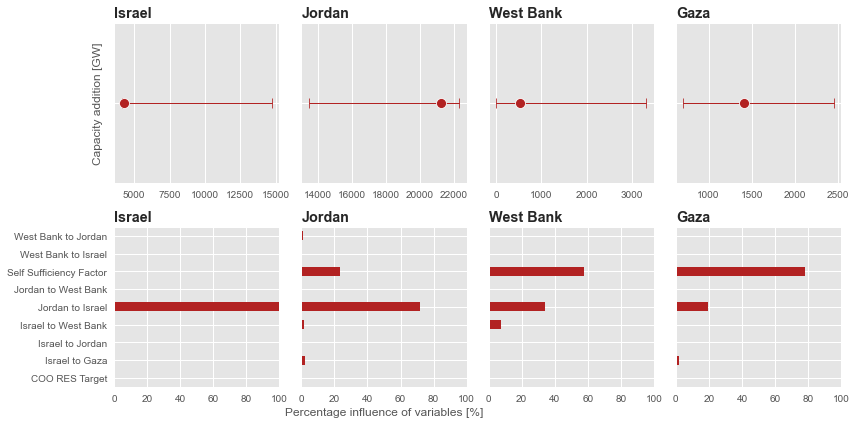

In [10]:
plt.style.use('ggplot')

f,ax=plt.subplots(nrows=2,ncols=4,figsize=(12,6))

# plot boxplot
min_max_avg_plot(df=combined_stats[combined_stats.variable.isin(['Israel'])],ax=ax[0,0])
min_max_avg_plot(df=combined_stats[combined_stats.variable.isin(['Jordan'])],ax=ax[0,1])
min_max_avg_plot(df=combined_stats[combined_stats.variable.isin(['West Bank'])],ax=ax[0,2])
min_max_avg_plot(df=combined_stats[combined_stats.variable.isin(['Gaza'])],ax=ax[0,3])

# combined_caps['Israel'].divide(1000).boxplot(ax=ax[0,0],showfliers=False,color=props,patch_artist=True)
# combined_caps['Jordan'].divide(1000).boxplot(ax=ax[0,1],showfliers=False,color=props,patch_artist=True)
# combined_caps['West Bank'].divide(1000).boxplot(ax=ax[0,2],showfliers=False,color=props,patch_artist=True)
# combined_caps['Gaza'].divide(1000).boxplot(ax=ax[0,3],showfliers=False,color=props,patch_artist=True)

# plot bar chart
calculate_relative_influence(israel_results).set_index('names').plot.barh(ax=ax[1,0],
                                                                          legend=False,color='firebrick')

calculate_relative_influence(jordan_results).set_index('names').plot.barh(ax=ax[1,1],
                                                                          legend=False,color='firebrick')

calculate_relative_influence(westbank_results).set_index('names').plot.barh(ax=ax[1,2],
                                                                            legend=False,color='firebrick')

calculate_relative_influence(gaza_results).set_index('names').plot.barh(ax=ax[1,3],
                                                                        legend=False,color='firebrick')

# formatting
ax[0,0].set_title('Israel',loc='left',fontweight='bold')
ax[0,1].set_title('Jordan',loc='left',fontweight='bold')
ax[0,2].set_title('West Bank',loc='left',fontweight='bold')
ax[0,3].set_title('Gaza',loc='left',fontweight='bold')

ax[1,0].set_title('Israel',loc='left',fontweight='bold')
ax[1,1].set_title('Jordan',loc='left',fontweight='bold')
ax[1,2].set_title('West Bank',loc='left',fontweight='bold')
ax[1,3].set_title('Gaza',loc='left',fontweight='bold')

ax[0,0].set_yticklabels([])
ax[0,1].set_yticklabels([])
ax[0,2].set_yticklabels([])
ax[0,3].set_yticklabels([])

ax[1,1].set_yticklabels([])
ax[1,2].set_yticklabels([])
ax[1,3].set_yticklabels([])

ax[0,0].set_ylabel('')
ax[0,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[0,3].set_ylabel('')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,3].set_xlabel('')

ax[1,0].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,2].set_ylabel('')
ax[1,3].set_ylabel('')

ax[1,0].set_xlim([0,100])
ax[1,1].set_xlim([0,100])
ax[1,2].set_xlim([0,100])
ax[1,3].set_xlim([0,100])

ax[0,0].set_ylabel('Capacity addition [GW]')
ax[1,1].set_xlabel('Percentage influence of variables [%]')

f.tight_layout()
f.savefig('../outputs/figures/global_sensitivity.pdf',bbox_inches='tight')